# Introduction
This notebook demonstrates the use of Scikit-learn's DecisionTreeClassifier to predict opioid overdoses (OD). It covers the entire process: data quality assessment, feature engineering, model training, evaluation, and interpretation.

### 1. Data Loading and Preparation

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix

# Suppress warnings for cleaner output
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [10]:
data = 'CaseStudy_training_data.xlsx'
df = pd.read_excel(data, sheet_name='Model_data')
df.head()

# Display basic info about the dataset
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Dataset contains 1000 rows and 22 columns.


,ID,OD,Low_inc,SURG,rx ds,A,B,C,D,E,...,I,J,K,L,M,N,R,S,T,V
0,1,1,1,0,794,0,0,0,1,1,...,1,1,0,1,1,1,1,0,0,0
1,2,1,1,0,457,0,0,1,0,1,...,1,1,0,0,0,1,1,1,0,0
2,3,1,1,1,722,0,1,0,1,1,...,1,1,1,0,1,0,1,0,0,0
3,4,0,1,0,262,0,1,0,0,1,...,1,0,1,1,1,1,1,1,1,0
4,5,1,1,0,780,0,0,0,0,1,...,1,0,1,0,1,0,1,0,0,0


### 2. Data Quality and Cleaning

In [11]:
# Drop missing values and duplicates
df_cleaned = df.dropna().drop_duplicates()

# Drop non-essential columns
df_cleaned = df_cleaned.drop(['ID'], axis=1)

# Rename columns for better readability
df_cleaned = df_cleaned.rename(columns={'rx ds': 'rx_ds'})

# Verify the cleaned data
print(f"Cleaned dataset contains {df_cleaned.shape[0]} rows and {df_cleaned.shape[1]} columns.")
df_cleaned.info()

Cleaned dataset contains 1000 rows and 21 columns.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   OD       1000 non-null   int64
 1   Low_inc  1000 non-null   int64
 2   SURG     1000 non-null   int64
 3   rx_ds    1000 non-null   int64
 4   A        1000 non-null   int64
 5   B        1000 non-null   int64
 6   C        1000 non-null   int64
 7   D        1000 non-null   int64
 8   E        1000 non-null   int64
 9   F        1000 non-null   int64
 10  H        1000 non-null   int64
 11  I        1000 non-null   int64
 12  J        1000 non-null   int64
 13  K        1000 non-null   int64
 14  L        1000 non-null   int64
 15  M        1000 non-null   int64
 16  N        1000 non-null   int64
 17  R        1000 non-null   int64
 18  S        1000 non-null   int64
 19  T        1000 non-null   int64
 20  V        1000 non-null   int64
dtypes: int64(2

### 3. Feature Engineering

In [12]:
# Bucketize 'rx_ds' into quartiles
df_cleaned['rx_ds_bucket'] = pd.qcut(
    df_cleaned['rx_ds'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Perform one-hot encoding for 'rx_ds_bucket'
df_encoded = pd.get_dummies(df_cleaned['rx_ds_bucket'], prefix='rx_ds_bucket')
df_cleaned = pd.concat([df_cleaned, df_encoded],
                       axis=1).drop(['rx_ds_bucket'], axis=1)

df_cleaned

,OD,Low_inc,SURG,rx_ds,A,B,C,D,E,F,...,M,N,R,S,T,V,rx_ds_bucket_Q1,rx_ds_bucket_Q2,rx_ds_bucket_Q3,rx_ds_bucket_Q4
0,1,1,0,794,0,0,0,1,1,1,...,1,1,1,0,0,0,0,0,0,1
1,1,1,0,457,0,0,1,0,1,1,...,0,1,1,1,0,0,0,0,1,0
2,1,1,1,722,0,1,0,1,1,1,...,1,0,1,0,0,0,0,0,0,1
3,0,1,0,262,0,1,0,0,1,1,...,1,1,1,1,1,0,0,1,0,0
4,1,1,0,780,0,0,0,0,1,1,...,1,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,0,1221,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,1
996,1,0,0,468,0,0,0,1,0,0,...,1,0,1,1,0,0,0,0,1,0
997,0,0,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
998,1,0,0,584,0,0,0,0,1,1,...,1,1,1,0,1,0,0,0,1,0


### 4. Model Training

Prepare Data for Model Training

In [20]:
# Define features and target
X = df_cleaned.drop(['OD', 'rx_ds'], axis=1)
y = df_cleaned['OD']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

#### 4.1 Model evaluation - Classification

In [21]:
tree_hyperparams = {
    'criterion': 'entropy',  # Measure for the quality of a split; 'entropy' uses information gain.
    'splitter': 'random',  # Strategy for splitting; 'random' chooses a random split, 'best' chooses the optimal one.
    'max_depth': 50,  # Maximum depth of the tree; limits how deep the tree can grow to prevent overfitting.
    'min_samples_split': 10,  # Minimum number of samples required to split a node; larger values make the tree simpler.
    'min_samples_leaf': 4,  # Minimum number of samples required at a leaf node; prevents leaves with too few samples.
    'max_features': None,  # Maximum features considered for splitting a node; None means all features are used.
    'max_leaf_nodes': 30,  # Maximum number of leaf nodes allowed; limits tree complexity.
    'min_impurity_decrease': 0.0,  # Minimum impurity reduction required to split a node; prevents insignificant splits.
    'min_weight_fraction_leaf': 0.15,  # Minimum fraction of the sample weights required at a leaf; avoids insignificant leaves.
    'class_weight': 'balanced',  # Adjusts class weights inversely proportional to their frequencies to handle imbalance.
    'ccp_alpha': 0.0,  # Complexity parameter for pruning; higher values prune more to reduce overfitting.
    'random_state': 42  # Seed for randomness to ensure reproducibility of the model results.
}

In [22]:
# Initialize and fit the model
tree_model = DecisionTreeClassifier(**tree_hyperparams)
tree_model.fit(X_train, y_train)

# Predict on test data
y_pred = tree_model.predict(X_test)

In [23]:
# Defining a function to calculate the metrics for the classifier
def calculate_metrics(y_test, y_pred, model, X_test):
    metrics = {}
    metrics["accuracy"] = accuracy_score(y_test, y_pred)
    metrics["precision"] = precision_score(y_test, y_pred)
    metrics["recall"] = recall_score(y_test, y_pred)
    metrics["f1"] = f1_score(y_test, y_pred)
    metrics["roc_auc"] = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = conf_matrix.ravel()
    
    metrics["ppv"] = TP / (TP + FP)
    metrics["npv"] = TN / (TN + FN)
    metrics["specificity"] = TN / (TN + FP)
    
    return metrics

In [24]:
# Define a function to calculate tthe metrics speciffically for the tree model
def calculate_tree_metrics(model, X_test, y_test):
    tree_metrics = {}
    tree_metrics["tree_depth"] = model.get_depth()
    tree_metrics["num_leaves"] = model.get_n_leaves()
    ccp_path = model.cost_complexity_pruning_path(X_test, y_test)
    tree_metrics["ccp_alphas"] = ccp_path.ccp_alphas
    tree_metrics["impurities"] = ccp_path.impurities
    
    return tree_metrics

In [25]:
# Calculate the metrics
y_pred = tree_model.predict(X_test)
classification_metrics = calculate_metrics(y_test, y_pred, tree_model, X_test)
tree_metrics = calculate_tree_metrics(tree_model, X_test, y_test)

# Classification Metrics DataFrame
results_classification = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (PPV)', 'Recall (Sensitivity)', 'Specificity', 'F1 Score', 'Positive Predictive Value (PPV)', 'Negative Predictive Value (NPV)', 'ROC AUC'],
    'Value': [classification_metrics['accuracy'], classification_metrics['precision'], classification_metrics['recall'], classification_metrics['specificity'], classification_metrics['f1'], classification_metrics['ppv'], classification_metrics['npv'], classification_metrics['roc_auc']]
})

# Round numerical values to 2 decimal places
results_classification['Value'] = results_classification['Value'].round(2)

# Decision Tree Metrics DataFrame
results_tree = pd.DataFrame({
    'Metric': ['Tree Depth', 'Number of Leaves', 'CCP Alphas', 'Impurities'],
    'Value': [tree_metrics['tree_depth'], tree_metrics['num_leaves'], tree_metrics['ccp_alphas'], tree_metrics['impurities']]
})

# Convert arrays to string for better representation
results_tree.loc[results_tree['Metric'].isin(['CCP Alphas', 'Impurities']), 'Value'] = results_tree.loc[results_tree['Metric'].isin(['CCP Alphas', 'Impurities']), 'Value'].apply(str)


### Visualizations

In [26]:
results_classification

,Metric,Value
0,Accuracy,0.66
1,Precision (PPV),0.46
2,Recall (Sensitivity),0.86
3,Specificity,0.57
4,F1 Score,0.60
5,Positive Predictive Value (PPV),0.46
6,Negative Predictive Value (NPV),0.91
7,ROC AUC,0.77


In [27]:
results_tree

,Metric,Value
0,Tree Depth,3
1,Number of Leaves,5
2,CCP Alphas,[0. 0.00358534 0.01108882 0.04355267 0...
3,Impurities,[0.7861074 0.78969274 0.80078156 0.84433423 1...


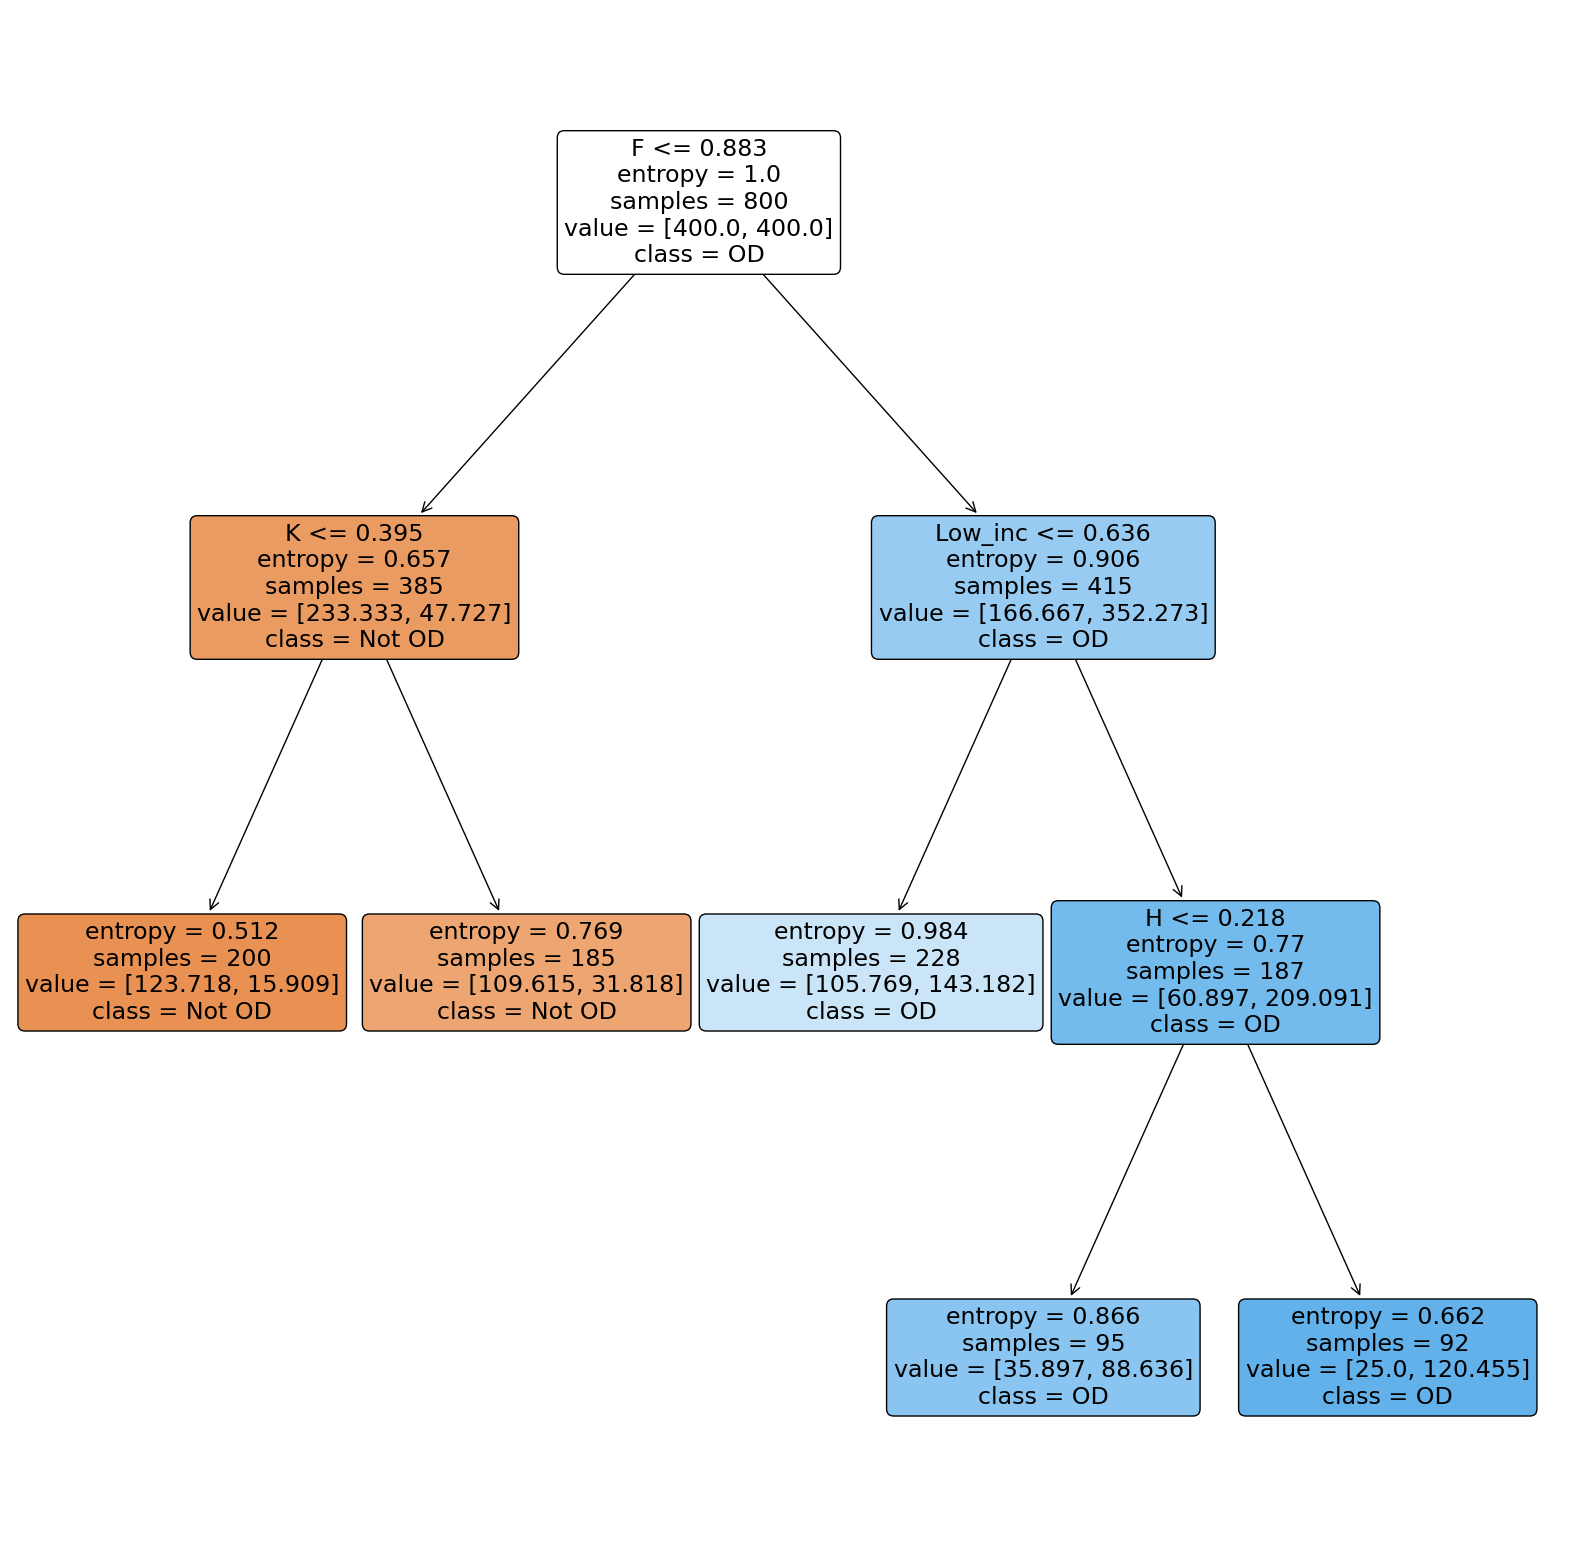

In [28]:
# Visualize the Decision Tree to nderstand the decision paths and criteria at each node
plt.figure(figsize=(20, 20))
plot_tree(tree_model, filled=True, rounded=True, class_names=["Not OD", "OD"], feature_names=X.columns)
plt.show()

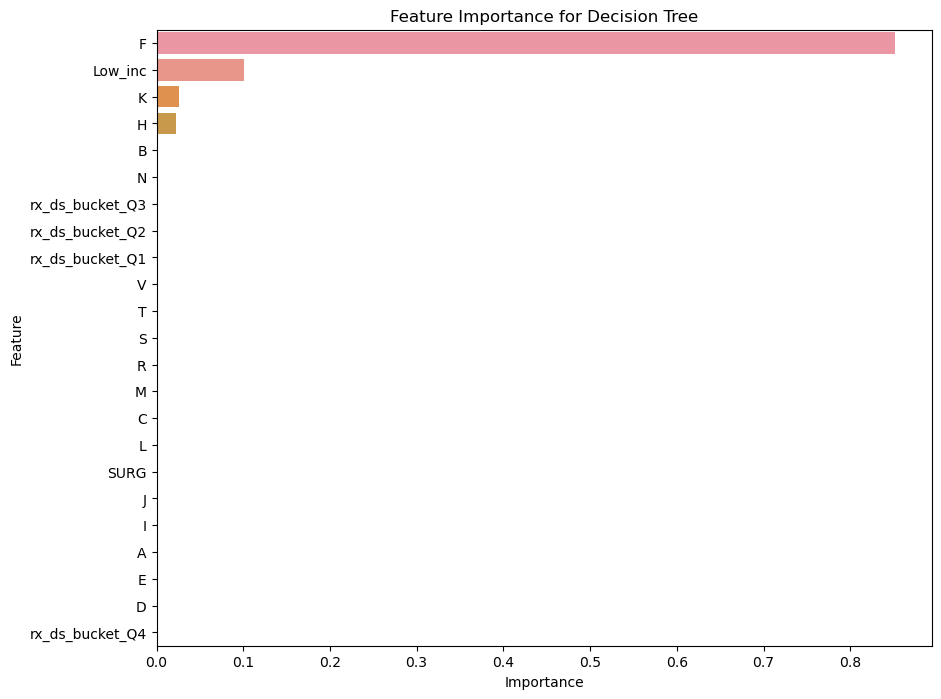

In [29]:
# Show Feature Importances
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': tree_model.feature_importances_}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

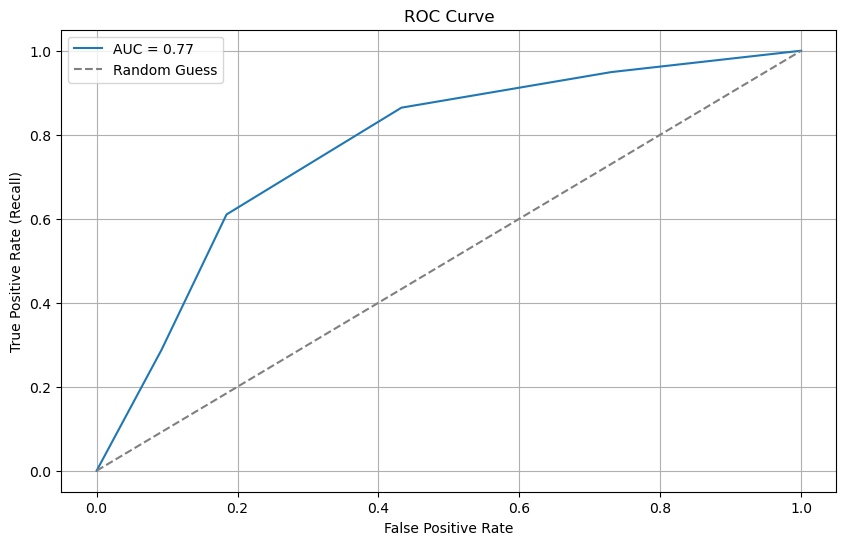

In [40]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC
# Probabilities for the positive class
y_test_proba = tree_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.grid(True)
plt.show()

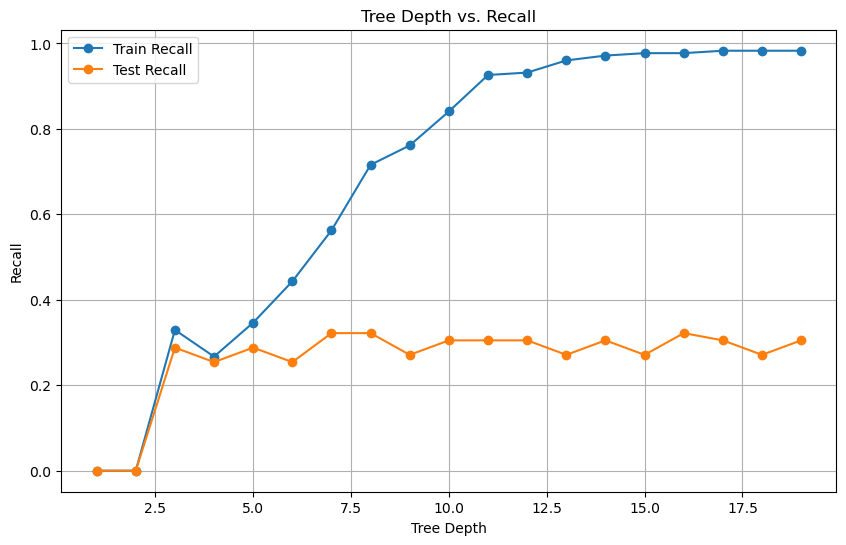

In [44]:
# Tree Complexity vs. Model Performance
max_depths = range(1, 20)  # Experiment with different tree depths
train_recalls = []
test_recalls = []

for depth in max_depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    train_recalls.append(recall_score(y_train, tree.predict(X_train)))
    test_recalls.append(recall_score(y_test, tree.predict(X_test)))

# Plot recall vs. tree depth
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_recalls, marker='o', label='Train Recall')
plt.plot(max_depths, test_recalls, marker='o', label='Test Recall')
plt.xlabel('Tree Depth')
plt.ylabel('Recall')
plt.title('Tree Depth vs. Recall')
plt.legend()
plt.grid(True)
plt.show()

- **Purpose:** Visualizes the relationship between tree depth and evaluation metrics (like recall or precision).
- **Why it's helpful:** Identifies the optimal tree depth for performance and complexity trade-off.

### Tree characteristics and metrics

In [45]:
sample_index = 0  # Choose a sample index from X_test
node_indicator = tree_model.decision_path(X_test).toarray()

# Display decision path for the chosen sample
print(f"Decision Path for Sample {sample_index}:")
for i, passed in enumerate(node_indicator[sample_index]):
    if passed:
        print(f"Node {i}: {tree_model.tree_.feature[i]} <= {tree_model.tree_.threshold[i]}")


Decision Path for Sample 0:
Node 0: 7 <= 0.8834673105196409
Node 1: 11 <= 0.3945456339952283
Node 6: -2 <= -2.0


In [ ]:
# Extract the decision paths for specific samples
decision_paths = tree_model.decision_path(X_test) # A decision path is the sequence of nodes that a particular sample traverses from the root node to a leaf node in the tree
decision_paths_array = decision_paths.toarray()

decision_paths_df = pd.DataFrame(decision_paths_array)
decision_paths_df.head()

,0,1,2,3,4,5,6,7,8
0,1,1,0,0,0,0,1,0,0
1,1,0,1,0,1,0,0,0,1
2,1,0,1,0,1,0,0,0,1
3,1,1,0,0,0,0,1,0,0
4,1,1,0,0,0,0,1,0,0


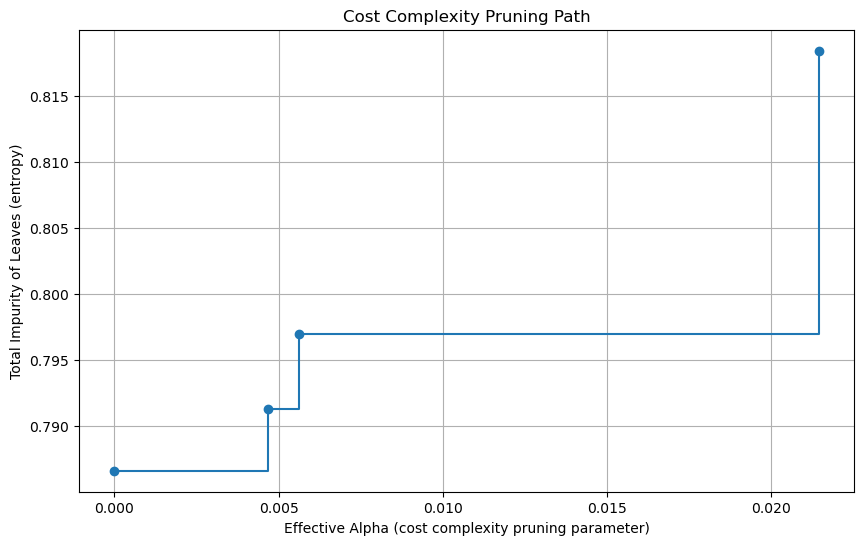

In [32]:
# Pruning to improve performance, and avoiding overfitting
ccp_path = tree_model.cost_complexity_pruning_path(X_train, y_train)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(ccp_path.ccp_alphas[:-1], ccp_path.impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("Effective Alpha (cost complexity pruning parameter)")
plt.ylabel("Total Impurity of Leaves (entropy)")
plt.title("Cost Complexity Pruning Path")
plt.grid(True)
plt.show()

- For each alpha, the tree is pruned by removing nodes that add little to the tree’s predictive power (This indicates that branches are being pruned, and the tree is becoming simpler)
- Impurity measures how "disordered" or "impure" the tree is at a given pruning stage
- Impurity increases as pruning removes branches, simplifying the tree
- At alpha = 0.0, the tree is unpruned, with the lowest impurity (most complex tree).